In [ ]:
%load_ext autoreload
%autoreload 2
from metnoulli_latent_simulation import (
    LatentPathwaySimulationConfig,
    simulate_metastasis_probabilities,
    plot_simulation_outputs,
    run_demo,
)


In [ ]:
# 1. Simulate latent metastasis dataset
config = LatentPathwaySimulationConfig(
    n_patients=300,
    n_sites=5,
    n_pathways=3,
    n_time=40,
)

simulation = simulate_metastasis_probabilities(config)
plot_simulation_outputs(simulation)



### From Simulation to Fit

We can now turn the simulated probabilities into a synthetic dataset, warm-start a MetNoulli-style model, and sketch the training loop. The cells below provide a scaffold you can adapt once the full model class is in place.


In [ ]:
from dataclasses import dataclass
from typing import Dict, Any

import numpy as np
from sklearn.cluster import SpectralClustering

@dataclass
class PreparedDataset:
    Y: np.ndarray
    event_times: np.ndarray
    covariates: np.ndarray
    baseline_logit: np.ndarray
    sites: np.ndarray
    time: np.ndarray


def prepare_simulated_dataset(simulation: Dict[str, np.ndarray], rng_seed: int = 123) -> PreparedDataset:
    """Sample metastasis indicators and event times from the simulator output."""
    rng = np.random.default_rng(rng_seed)

    probs = simulation["probs"]  # (patients, sites, time)
    Y = rng.binomial(1, probs)

    # First time a metastasis appears per patient/site; fallback to censoring at final bin
    event_times = np.full(probs.shape[:2], probs.shape[2] - 1, dtype=int)
    for i in range(probs.shape[0]):
        for s in range(probs.shape[1]):
            met_indices = np.where(Y[i, s] == 1)[0]
            if met_indices.size > 0:
                event_times[i, s] = met_indices[0]

    return PreparedDataset(
        Y=Y,
        event_times=event_times,
        covariates=simulation["covariates"],
        baseline_logit=np.log(simulation["baseline_prob"] / (1 - simulation["baseline_prob"])),
        sites=simulation["sites"],
        time=simulation["time"],
    )


def hot_start_from_counts(dataset: PreparedDataset, n_pathways: int) -> Dict[str, Any]:
    """Derive ψ and cluster assignments from simulated counts (Noulli-style contrast)."""
    Y_avg = dataset.Y.mean(axis=0)  # (sites, time)
    similarity = np.corrcoef(Y_avg)
    similarity = np.nan_to_num(similarity, nan=0.0)
    affinity = (similarity + 1.0) / 2.0

    spectral = SpectralClustering(
        n_clusters=n_pathways,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=1,
    )
    clusters = spectral.fit_predict(affinity)

    psi_config = {
        "in_cluster": 1.0,
        "out_cluster": -2.0,
        "noise_in": 0.1,
        "noise_out": 0.01,
    }

    rng = np.random.default_rng(42)
    psi_init = np.zeros((n_pathways, dataset.sites.size))
    for k in range(n_pathways):
        membership = clusters == k
        psi_init[k, membership] = psi_config["in_cluster"] + psi_config["noise_in"] * rng.standard_normal(
            membership.sum()
        )
        psi_init[k, ~membership] = psi_config["out_cluster"] + psi_config["noise_out"] * rng.standard_normal(
            (~membership).sum()
        )

    return {"clusters": clusters, "psi_init": psi_init}


def train_metnoulli_stub(dataset: PreparedDataset, hot_start: Dict[str, Any]) -> None:
    """Placeholder for the actual MetNoulli training loop with explanatory comments."""
    print("Step 1: Instantiate your MetNoulli model class with dataset dimensions.")
    print("Step 2: Load hot-start parameters (ψ, baseline logits, covariates).")
    print("Step 3: Build tensors (Y, event_times, covariates) and send to device.")
    print("Step 4: Run Adam loop: forward → loss → backward → optimizer.step().")
    print("Step 5: Monitor losses, calibration, trajectory plots.")


In [ ]:
# 2. Sample metastasis indicators and hot-start ψ
hot_start = None

dataset = prepare_simulated_dataset(simulation)
hot_start = hot_start_from_counts(dataset, n_pathways=config.n_pathways)

print("Prepared dataset:")
print(f"  Y shape: {dataset.Y.shape}")
print(f"  Event times shape: {dataset.event_times.shape}")
print(f"  Baseline logit shape: {dataset.baseline_logit.shape}")
print(f"  Hot-start ψ shape: {hot_start['psi_init'].shape}")

In [ ]:
# 3. Train MetNoulli latent model
import os
import sys

import torch

sys.path.append("/Users/sarahurbut/metnoulli/src")  # ensure module import path

from metnoulli_latent_model import (
    MetNoulliLatentModel,
    MetNoulliBatch,
    train_metnoulli_model,
)

baseline_logit_tensor = torch.tensor(dataset.baseline_logit, dtype=torch.float32)
covariate_tensor = torch.tensor(dataset.covariates, dtype=torch.float32)

model = MetNoulliLatentModel(
    n_patients=dataset.Y.shape[0],
    n_sites=dataset.Y.shape[1],
    n_time=dataset.Y.shape[2],
    n_pathways=config.n_pathways,
    n_covariates=covariate_tensor.shape[1],
    baseline_logit=baseline_logit_tensor,
    covariates=covariate_tensor,
    psi_init=hot_start["psi_init"],
)

batch = MetNoulliBatch(
    Y=torch.tensor(dataset.Y, dtype=torch.float32),
    event_times=torch.tensor(dataset.event_times, dtype=torch.long),
    covariates=covariate_tensor,
)

results = train_metnoulli_model(model, batch, n_epochs=1000, learning_rate=5e-3)
print("Final training loss:", results["losses"][-1])


In [ ]:

plt.figure(figsize=(6, 4))
plt.plot(results["losses"], marker="o", markersize=3, linewidth=1)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# === Quantitative recovery diagnostics ===
phi_true = simulation["phi"]  # (K, D, T)
theta_true = simulation["theta"]  # (N, K, T)
probs_true = simulation["probs"]  # (N, D, T)

phi_est = results["phi"]
theta_est = results["theta"]
probs_est = results["probs"]

# Pathway-wise correlation between true and recovered phi (flattened over site/time)
phi_corr = []
for k in range(phi_true.shape[0]):
    corr = np.corrcoef(phi_true[k].ravel(), phi_est[k].ravel())[0, 1]
    phi_corr.append(corr)

# Patient-wise mean squared error for theta trajectories
theta_mse = np.mean((theta_true - theta_est) ** 2, axis=(2))  # (N, K)
per_patient_theta_mse = theta_mse.mean(axis=1)

# Probability RMSE across all patients/sites/time
probs_rmse = np.sqrt(np.mean((probs_true - probs_est) ** 2))

print("Phi correlations per pathway:", np.round(phi_corr, 3))
print("Median theta MSE across pathways per patient:", np.round(np.median(theta_mse, axis=1), 4)[:5], "...")
print("Global probability RMSE:", round(probs_rmse, 4))


In [ ]:
# Align estimated pathways to true ones (permutation + sign)
from scipy.optimize import linear_sum_assignment

corr_matrix = np.zeros((config.n_pathways, config.n_pathways))
for k_true in range(config.n_pathways):
    for k_est in range(config.n_pathways):
        corr = np.corrcoef(
            phi_true[k_true].ravel(),
            phi_est[k_est].ravel()
        )[0, 1]
        corr_matrix[k_true, k_est] = corr

row_ind, col_ind = linear_sum_assignment(-np.abs(corr_matrix))
phi_corr_aligned = corr_matrix[row_ind, col_ind]

phi_est = phi_est[col_ind]
theta_est = theta_est[:, col_ind]
psi_est = results["psi"][col_ind]

for idx, corr in enumerate(phi_corr_aligned):
    if corr < 0:
        phi_est[idx] *= -1
        theta_est[:, idx] *= -1
        psi_est[idx] *= -1
        phi_corr_aligned[idx] *= -1

print("Aligned φ correlations after sign correction:", np.round(phi_corr_aligned, 3))



In [ ]:
# Recompute diagnostics with aligned components
phi_corr_aligned = [np.corrcoef(phi_true[k].ravel(), phi_est[k].ravel())[0, 1] for k in range(config.n_pathways)]

theta_mse_aligned = np.mean((theta_true - theta_est) ** 2, axis=2)
probs_rmse_aligned = np.sqrt(np.mean((probs_true - results["probs"]) ** 2))

print("Aligned φ correlations:", np.round(phi_corr_aligned, 3))
print("Median theta MSE (aligned):", np.round(np.median(theta_mse_aligned, axis=1), 4)[:5], "...")
print("Probability RMSE (aligned):", round(probs_rmse_aligned, 4))


In [ ]:
# Compare recovered psi to hot-start and true pathway pattern
plt.figure(figsize=(12,4))
sns.heatmap(results["psi"], cmap="RdBu_r", center=0)
plt.title("Recovered ψ")

plt.figure(figsize=(12,4))
sns.heatmap(simulation["phi"].mean(axis=2), cmap="viridis")
plt.title("True latent signature (avg)")

# Theta trajectories for a patient
patient_idx = 0
plt.plot(dataset.time, results["theta"][patient_idx].T)
plt.title(f"Patient {patient_idx+1} pathway weights")

In [ ]:
dataset = prepare_simulated_dataset(simulation)
hot_start = hot_start_from_counts(dataset, n_pathways=config.n_pathways)

print("Prepared dataset:")
print(f"  Y shape: {dataset.Y.shape}")
print(f"  Event times shape: {dataset.event_times.shape}")
print(f"  Baseline logit shape: {dataset.baseline_logit.shape}")
print(f"  Hot-start ψ shape: {hot_start['psi_init'].shape}")

train_metnoulli_stub(dataset, hot_start)


/Users/sarahurbut/metnoulli/demofiles/metnoulli_latent_simulation.py:290: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig_probs.tight_layout()
/Users/sarahurbut/metnoulli/demofiles/metnoulli_latent_simulation.py:311: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig_cum.tight_layout()


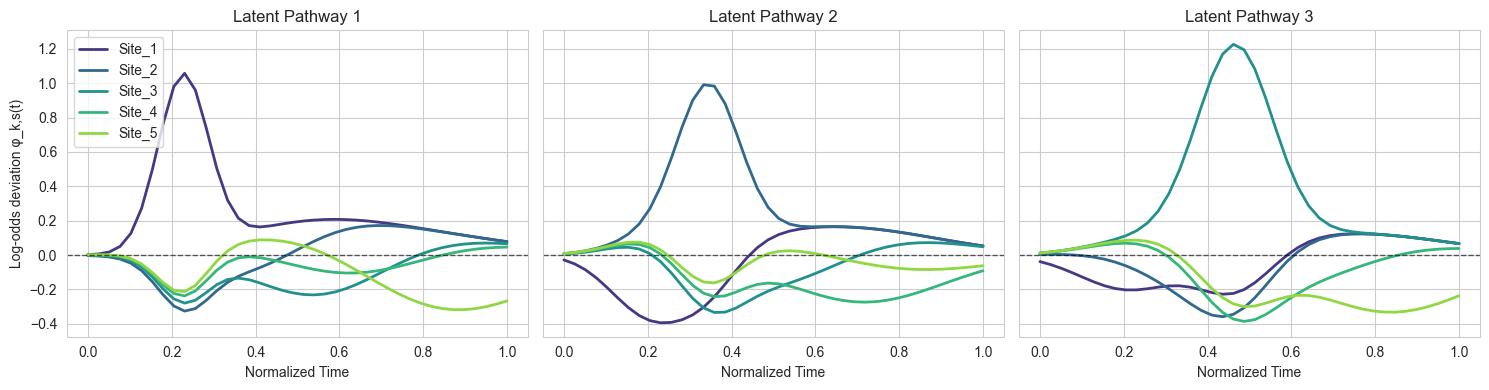

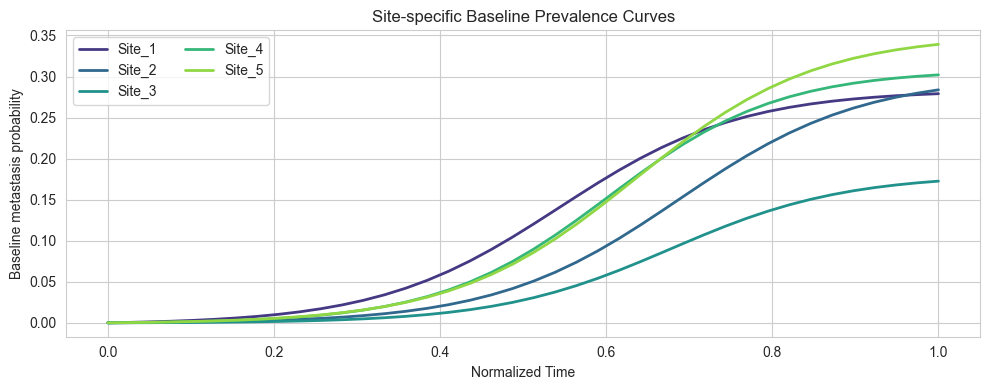

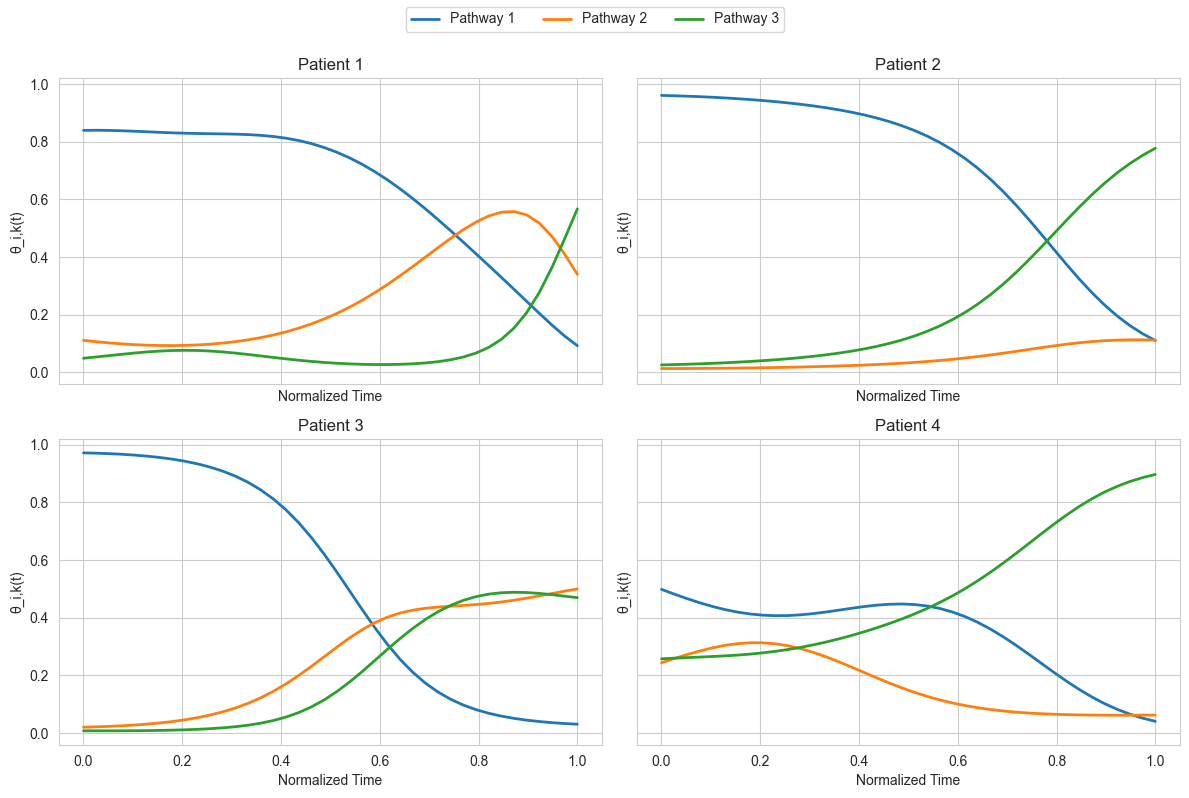

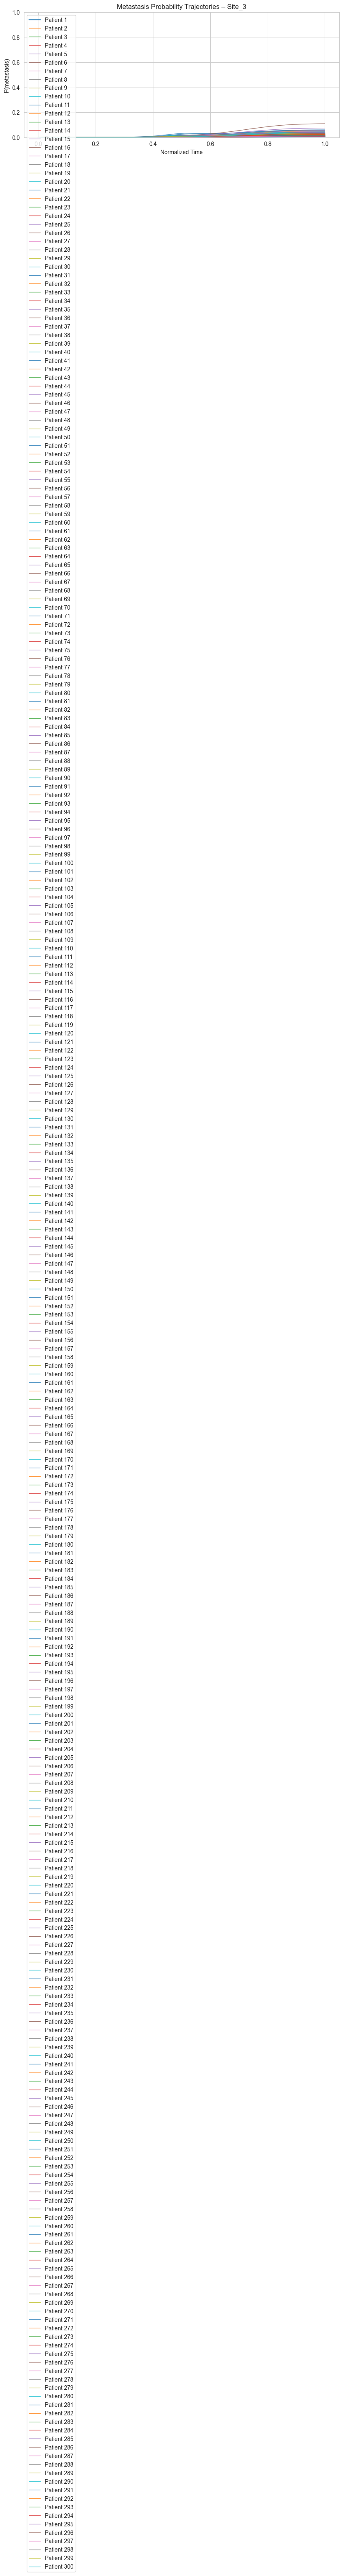

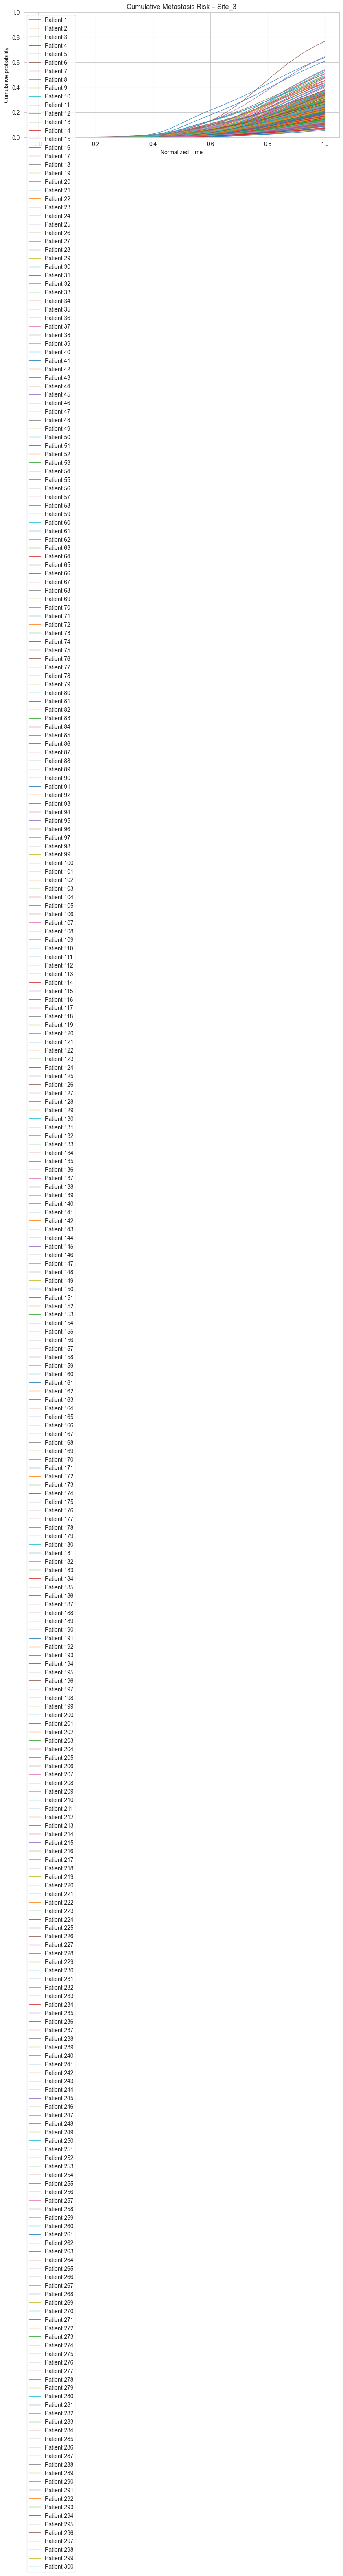

Epoch 001 | Loss 12.3323
Epoch 025 | Loss 10.4552
Epoch 050 | Loss 9.1683
Epoch 075 | Loss 8.2374
Epoch 100 | Loss 7.4685
Epoch 125 | Loss 6.7731
Epoch 150 | Loss 6.1263
Epoch 175 | Loss 5.5373
Epoch 200 | Loss 5.0254
Epoch 225 | Loss 4.6023
Epoch 250 | Loss 4.2661
Epoch 275 | Loss 4.0042
Epoch 300 | Loss 3.8004
Epoch 325 | Loss 3.6397
Epoch 350 | Loss 3.5099
Epoch 375 | Loss 3.4023
Epoch 400 | Loss 3.3107
Epoch 425 | Loss 3.2310
Epoch 450 | Loss 3.1600
Epoch 475 | Loss 3.0957
Epoch 500 | Loss 3.0364
Epoch 525 | Loss 2.9811
Epoch 550 | Loss 2.9290
Epoch 575 | Loss 2.8794
Epoch 600 | Loss 2.8320
Epoch 625 | Loss 2.7862
Epoch 650 | Loss 2.7419
Epoch 675 | Loss 2.6986
Epoch 700 | Loss 2.6560
Epoch 725 | Loss 2.6140
Epoch 750 | Loss 2.5723
Epoch 775 | Loss 2.5308
Epoch 800 | Loss 2.4893
Epoch 825 | Loss 2.4478
Epoch 850 | Loss 2.4064
Epoch 875 | Loss 2.3649
Epoch 900 | Loss 2.3236
Epoch 925 | Loss 2.2825
Epoch 950 | Loss 2.2418
Epoch 975 | Loss 2.2015
Epoch 1000 | Loss 2.1616
Final trainin

In [2]:
from metnoulli_latent_pipeline import main

main(plot=True)   